In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pylab as plt
import datetime
import locale
locale.setlocale(locale.LC_NUMERIC, "")
import subprocess


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Conv1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.backend import clear_session

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
ASK_FNAME = "EURUSD_ASK_01.05.2018-01.05.2019.csv"
BID_FNAME = "EURUSD_BID_01.05.2018-01.05.2019.csv"
ASK_DF=[]
BID_DF=[]

WINDOW=90
FORECAST=45
EMB_SIZE=10
STEP=1  #best is 75
TRAIN_TEST_PERCENTAGE=0.9
#SAVE_NAME = "classification_model.hdf5"
#LOAD_NAME = "classification_model.hdf5"
ENABLE_CSV_OUTPUT = 1
NAME_CSV = "classification"
TRAINING = 1
TESTING = 1
NUMBER_EPOCHS = 50
TRADING_DAYS = 4
BID_QUERY='index="forex" sourcetype="stock:quote:eur_usd" NOT date_wday="saturday" NOT date_wday="sunday" earliest=-4mon@d latest=-2mon@d| where date_hour>6 AND date_hour<21 | eval _time=strftime(_time,"%m-%d-%Y-%H:%M:%S") | eval bid.v=volume | eval ask.v=volume| table _time bid.o,bid.h,bid.l,bid.c,bid.v,date_wday,date_hour,date_minute,date_second | sort _time|head 20000 '
ASK_QUERY='index="forex" sourcetype="stock:quote:eur_usd" NOT date_wday="saturday" NOT date_wday="sunday"  earliest=-4mon@d latest=-2mon@d|  where date_hour>6 AND date_hour<21 |eval _time=strftime(_time,"%m-%d-%Y-%H:%M:%S") | eval bid.v=volume | eval ask.v=volume| table _time ask.o,ask.h,ask.l,ask.c,ask.v,date_wday,date_hour,date_minute,date_second | sort _time | head 20000'

In [3]:
# Modified to comply with predict.py

LOAD_NAME = "model.hdf5"
SAVE_NAME = "model_save.hdf5"
TRAINING = 1
SPLUNK_BIN="/Applications/Splunk/bin/splunk"
SPLUNK_OPTIONS="-auth admin:idvxch88"

# Dataset Preparation

In [4]:
def df_sample(df):
    print ('\nINSPECTING DATABASE..\n')
    print ('DATABASE SIZE [',len(df),']')
    
    print ('SAMPLE VALUES..')
    
    r = int(random.random()*len(df))
    sample = df[r:r+WINDOW]
    target = df[r:r+WINDOW+FORECAST]
    
    plt.plot(sample.Open)
    plt.plot(sample.High)
    plt.plot(sample.Low)
    plt.plot(target.Close)
    #plt.plot(sample.Volume)
    plt.show()    

def df_plot(df):
    print ('\nINSPECTING DATABASE..\n')
    print ('DATABASE SIZE [',len(df),']')
    
    for col in df.columns:
        if col!='Datetime'and col!='Volume_x' and col !='Volume_y':
            plt.plot(df[col])
    plt.show()

def df_dead(df):
    
    _is_dead = 0
    
    print ('\nINSPECTING DATABASE..\n')
    print ('DATABASE SIZE [',len(df),']')
    
    
    deads = []
    
    for i in range(len(df.Close.values)):
        if(df.Close.values[i]==df.Open.values[i]==df.High.values[i]==df.Low.values[i]):
            if(_is_dead==0):
                #print '_is_dead from', i
                deads.append(i)
            _is_dead = 1
        if(df.Close.values[i]!=df.Open.values[i]):
            if(_is_dead==1):
                #print '_is_dead to', i
                #print '-'
                deads.append(i)
            _is_dead = 0
        
    return deads

def health_check(df):
    flag=1
    deads = df_dead(df)
    long_deads, i =[], 0
    
    while i<len(deads)-1:
        dead_len = deads[i+1]-deads[i]
        
        if(dead_len>100):
            long_deads.append(deads[i])
            long_deads.append(deads[i+1])
            print ('WARNING long dead period [',deads[i],'] to [',deads[i+1],']')
            flag=0
        i=i+2
    
    print('Data from '+str(df.Datetime[df.index[0]])+' to '+ str(df.Datetime[df.index[len(df.index)-1]]))
    print('..check completed')
    if flag:
        print ("no DEAD periods")
    return long_deads
    
        

In [5]:
def get_splunk_quotes(query=BID_QUERY):
    lines=[]
    out=subprocess.run([SPLUNK_BIN, 'search',query,SPLUNK_OPTIONS,"-maxout","0"],stdout=subprocess.PIPE, text=True, bufsize=-1)

    for line in out.stdout.splitlines():
        if line.find('_time') == -1 and line.find('--') == -1:
            lines.append(line.split())

    print ("Lines Count: ",len(lines))
    try:
        df=pd.DataFrame.from_records(lines,coerce_float=True)
    except Exception as e:
        print("Dataframe.from_records exception: ",e)
        exit()

    print("Splunk Query Results\nHead:")
    print(df.head())
    print("Tail:")
    print(df.tail())
    

    
    df = df.rename(columns={ df.columns[0] : 'Datetime', df.columns[1] : 'Open', df.columns[2] : 'High', df.columns[3] : 'Low', df.columns[4]: 'Close', df.columns[5] : 'Volume',df.columns[6]: 'Weekday', df.columns[7]: 'Hour', df.columns[8]:'Minute',df.columns[9]:'Second'}) 
    df[["Open","High","Low","Close","Volume"]] = df[["Open","High","Low","Close","Volume"]].astype(float)
    df[["Minute","Hour","Second"]]=df[["Minute","Hour","Second"]].astype(int)
    print(df.dtypes)     
    
    # convert numerics to floats and time
    #for i in range(0,len(df)):
        #df.loc[i,('Datetime')]=datetime.datetime.strptime(df.loc[i,('Datetime')]).replace("-"," ",1)
        #df.loc[i, ('Datetime')] = datetime.datetime.strptime(df.loc[i, ('Datetime')], '%d.%m.%Y-%H:%M:%S.%f')
        #print(i)

        # Make sure to skip Weekday, Month, etc on end
     #   for col in range(1,len(df.columns)-4):
            #print("Float conversion for: ", df.columns[col], " Value: ", df.loc[i,df.columns[col]])
      #      df.loc[i,df.columns[col]]=float(df.loc[i,df.columns[col]])
    
    return df
    

In [6]:
def dataset(rtf_input, START=0, END=0, SLICING=0, type="bid"):
    #if(!slicing) the function just download and not clean the whole dataset
    #if slicing the function is slicing and cleaning the dataset from START to END
    print ('dataset preparation.. (cleaning size ', END - START,')')
    #df = pd.read_table(rtf_input, header=8,sep=",")
    #df = pd.read_csv(rtf_input, header=8,sep=",")
    global BID_DF
    global ASK_DF
    global BID_QUERY
    global ASK_QUERY
    
  #  print ("BID/ASK Len: ", len(BID_DF),"/",len(ASK_DF))
    if (len(BID_DF)== 0 or len(ASK_DF)==0):
        print("Getting splunk quotes")
        BID_DF=get_splunk_quotes(BID_QUERY)
        ASK_DF=get_splunk_quotes(ASK_QUERY)

    if(type == "bid"):
        df=BID_DF
    else:
        df=ASK_DF
    
    if(SLICING):
        df = df[START:END]
        #print("Start:",START,"End:",END)
        #print("Returning",df.head())

    def find_hour(df, hour='07:00:00'):
        vec = []
        for i in range(0,len(df.Datetime)):
            currhour="%02d:%02d:%02d" % (df.Hour[i],df.Minute[i],df.Second[i])
            if(currhour == hour):
                vec.append(i)

        return vec
        
                
    if (SLICING==0):
        STARTS = find_hour(df,'07:00:00')
        ENDS = find_hour(df,'20:59:00')
        
        if(ENDS[0] < STARTS[0]):
            ends=ENDS
            ENDS=STARTS
            STARTS=ends
            
        print ("dataset(): STARTS",STARTS)
        print ("dataset(): ENDS",ENDS)
        
        # in case the data ends mid-day
        if(len(STARTS) > len(ENDS)):
            del STARTS[len(ENDS)-1:]
            print("Cleaned up STARTS > ENDS")
            
        return df, STARTS, ENDS
    
    else:
        #print('dataset ready to use')
        return df

def dataset_check(RTF_INPUT=ASK_FNAME):
    #check the overall database health with no cleaning
    df, STARTS, ENDS = dataset(RTF_INPUT)
    health_check(df)
    print('\nDATASET NOT CLEANED\n')
    print(df.head())
    print(df.tail())
    return STARTS, ENDS

In [7]:
#procedure for dataframe (clean dataset) preparation
#_START and _END are the two vector with starting and end values for the slicing

def full_df(STARTS, ENDS, ASK_FNAME=ASK_FNAME, BID_FNAME=BID_FNAME):
    ask_df = []
    bid_df = []
    print("Getting full DF - STARTS/ENDS len",len(STARTS),"/",len(ENDS))
    for i in range(0,len(STARTS)):
        ask_df.append(dataset(ASK_FNAME,STARTS[i],ENDS[i],SLICING=1,type="ask"))
        bid_df.append(dataset(BID_FNAME,STARTS[i],ENDS[i],SLICING=1,type="bid"))
            
    ask_df= pd.concat(ask_df)
    bid_df= pd.concat(bid_df)
    
    timecols = ['Weekday','Hour','Minute','Second']
    bid_df.drop(timecols, inplace=True, axis=1)
    ask_df.drop(timecols, inplace=True, axis=1)
    #deads = health_check(bid_df)
    
    df = pd.merge(ask_df,bid_df, on="Datetime")
    df = df.rename(columns={ df.columns[0] : 'Datetime', df.columns[1] : 'Open_x', df.columns[2] : 'High_x', df.columns[3] : 'Low_x', df.columns[4]: 'Close_x', df.columns[5] : 'Volume_x', df.columns[6] : 'Open_y', df.columns[7] : 'High_y', df.columns[8] : 'Low_y', df.columns[9]: 'Close_y', df.columns[10] : 'Volume_y' })
    
    print('\nDATASET CLEANED\n')
    print(df.head())
    print(df.tail())
    #df_plot(df)
    
    return df

In [8]:
print (BID_FNAME)
ASK_DF=[]
BID_DF=[]
STARTS, ENDS = dataset_check(BID_FNAME)
df = full_df(STARTS,ENDS)
df.head()


EURUSD_BID_01.05.2018-01.05.2019.csv
dataset preparation.. (cleaning size  0 )
Getting splunk quotes
Lines Count:  10000
Splunk Query Results
Head:
                     0        1        2        3                   4  \
0  01-28-2019-07:00:00  1.14068  1.14093  1.14063             1.14088   
1  01-28-2019-07:01:00  1.14089  1.14093  1.14086             1.14091   
2  01-28-2019-07:02:00   1.1409  1.14091  1.14077  1.1408200000000002   
3  01-28-2019-07:03:00  1.14083  1.14093  1.14083             1.14093   
4  01-28-2019-07:04:00  1.14093  1.14093  1.14075             1.14076   

                   5       6  7  8  9  
0             645.65  monday  7  0  0  
1  672.6700000000001  monday  7  1  0  
2              801.7  monday  7  2  0  
3             638.52  monday  7  3  0  
4             532.02  monday  7  4  0  
Tail:
                        0                   1                   2        3  \
9995  02-12-2019-19:35:00             1.13303             1.13303    1.133   
9996  02-12

,Datetime,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y
0,01-28-2019-07:00:00,1.14069,1.14084,1.14069,1.14071,645.65,1.14068,1.14093,1.14063,1.14088,645.65
1,01-28-2019-07:01:00,1.14070,1.14096,1.14066,1.14090,672.67,1.14089,1.14093,1.14086,1.14091,672.67
2,01-28-2019-07:02:00,1.14091,1.14097,1.14090,1.14092,801.70,1.14090,1.14091,1.14077,1.14082,801.70
3,01-28-2019-07:03:00,1.14093,1.14093,1.14080,1.14085,638.52,1.14083,1.14093,1.14083,1.14093,638.52
4,01-28-2019-07:04:00,1.14085,1.14095,1.14085,1.14095,532.02,1.14093,1.14093,1.14075,1.14076,532.02


In [9]:
df.tail()

,Datetime,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y
8385,02-08-2019-20:54:00,1.13231,1.13231,1.13231,1.13231,0.0,1.13207,1.13207,1.13207,1.13207,0.0
8386,02-08-2019-20:55:00,1.13231,1.13231,1.13231,1.13231,0.0,1.13207,1.13207,1.13207,1.13207,0.0
8387,02-08-2019-20:56:00,1.13231,1.13231,1.13231,1.13231,0.0,1.13207,1.13207,1.13207,1.13207,0.0
8388,02-08-2019-20:57:00,1.13231,1.13231,1.13231,1.13231,0.0,1.13207,1.13207,1.13207,1.13207,0.0
8389,02-08-2019-20:58:00,1.13231,1.13231,1.13231,1.13231,0.0,1.13207,1.13207,1.13207,1.13207,0.0


# DATAFRAME PREPARATION

In [10]:
def ternary_tensor(Time,aO,aH,aL,aC,aV,bO,bH,bL,bC,bV):
    count=0
    X,Y = [],[]
    print("Doing ternary tensor with time length of ",len(Time)," and ", STEP , "steps")
    for i in range(0, len(Time), STEP):
        #print (i)
        count=count+1

        try:
            #ask open, ask high.. bid close, bid volume
            ao = aO[i:i+WINDOW]
            ah = aH[i:i+WINDOW]
            al = aL[i:i+WINDOW]
            ac = aC[i:i+WINDOW]
            av = aV[i:i+WINDOW]
            
            if(np.sum(av) == 0):
                next
                
            #zscore on time window interval
            ao = (np.array(ao) - np.mean(ao)) / np.std(ao)
            ah = (np.array(ah) - np.mean(ah)) / np.std(ah)
            al = (np.array(al) - np.mean(al)) / np.std(al)
            ac = (np.array(ac) - np.mean(ac)) / np.std(ac)

            
            bo = bO[i:i+WINDOW]
            bh = bH[i:i+WINDOW]
            bl = bL[i:i+WINDOW]
            bc = bC[i:i+WINDOW]
            bv = bV[i:i+WINDOW]
            #zscore on time window interval
            bo = (np.array(bo) - np.mean(bo)) / np.std(bo)
            bh = (np.array(bh) - np.mean(bh)) / np.std(bh)
            bl = (np.array(bl) - np.mean(bl)) / np.std(bl)
            bc = (np.array(bc) - np.mean(bc)) / np.std(bc)

            #no action scenario
           
            bet_ask = aC[i+WINDOW]
            bet_bid = bC[i+WINDOW]
            bet_time = Time[i+WINDOW]
            prediction_ask = aC[i+WINDOW+FORECAST]
            prediction_bid = bC[i+WINDOW+FORECAST]
            prediction_time = Time[i+WINDOW+FORECAST]
    
            #bet_time=datetime.datetime.strptime(bet_time, '%d.%m.%Y %H:%M:%S.%f %Z%z')
            if(prediction_bid>bet_ask):
                #if the bid price at prediction time is greater then ask price at bet time: is a put
                y_i = [1,0,0]
            elif(prediction_ask<bet_bid):
                    #if the ask price at prediction time is lower then bid price at bet time: is a call
                y_i = [0,1,0]
            else:
                y_i = [0,0,1]

            x_i = np.column_stack((ao,ah,al,ac,av,bo,bh,bl,bc,av))
            #print (y_i,bet_ask,bet_bid,bet_time,prediction_ask,prediction_bid,prediction_time)
                
            X.append(x_i)
            Y.append(y_i)
            
            if count%500==0:
                print (count, 'windows sized')
                print (y_i,bet_ask,bet_bid,bet_time,prediction_ask,prediction_bid,prediction_time)
                print(ao,ah,al,ac,av,bo,bh,bl,bc,av)
        except Exception as e:
            print (e)
            #print (ao,ah,al,ac,bo,bh,bh,bl,bc)
            pass

    return X,Y

In [11]:
def format_data(df,ternary=1,binary=0):
    print ("format_data:\n",df)
    Time = df.Datetime
    aO = df.Open_x.tolist()
    aH = df.High_x.tolist()
    aL = df.Low_x.tolist()
    aC = df.Close_x.tolist()
    aV = df.Volume_x.tolist()
    bO = df.Open_y.tolist()
    bH = df.High_y.tolist()
    bL = df.Low_y.tolist()
    bC = df.Close_y.tolist()
    bV = df.Volume_y.tolist()
    
    if(ternary==1):
        return ternary_tensor(Time,aO,aH,aL,aC,aV,bO,bH,bL,bC,bV)

    elif(binary==1):
        return binary_tensor(Time,aO,aH,aL,aC,aV,bO,bH,bL,bC,bV)


In [12]:
def spread(Y):
    still = 0
    for vec in Y:
        if vec[2]==1:
            still=still+1
    spread =still*100/len(Y)
    print (spread,"%")
    return spread

In [13]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    # shuffling of training data
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def remove_nan_examples(data):
    #some basic util functions
    newX = []
    for i in range(len(data)):
        if np.isnan(data[i]).any() == False:
            newX.append(data[i])
    return newX

In [14]:
def train_test(X, y, percentage=TRAIN_TEST_PERCENTAGE):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

In [15]:
#X,Y = format_data(df[60000:]) # why 60,0000?
X,Y = format_data(df)
print ("Len X/Y",len(X)," / ",len(Y))

format_data:
                  Datetime   Open_x   High_x    Low_x  Close_x  Volume_x  \
0     01-28-2019-07:00:00  1.14069  1.14084  1.14069  1.14071    645.65   
1     01-28-2019-07:01:00  1.14070  1.14096  1.14066  1.14090    672.67   
2     01-28-2019-07:02:00  1.14091  1.14097  1.14090  1.14092    801.70   
3     01-28-2019-07:03:00  1.14093  1.14093  1.14080  1.14085    638.52   
4     01-28-2019-07:04:00  1.14085  1.14095  1.14085  1.14095    532.02   
5     01-28-2019-07:05:00  1.14095  1.14096  1.14078  1.14078    446.83   
6     01-28-2019-07:06:00  1.14080  1.14083  1.14077  1.14079    604.79   
7     01-28-2019-07:07:00  1.14080  1.14095  1.14080  1.14090    546.74   
8     01-28-2019-07:08:00  1.14091  1.14103  1.14090  1.14101    473.96   
9     01-28-2019-07:09:00  1.14101  1.14101  1.14084  1.14087    520.32   
10    01-28-2019-07:10:00  1.14088  1.14101  1.14086  1.14099    464.40   
11    01-28-2019-07:11:00  1.14099  1.14099  1.14094  1.14099    482.62   
12    01-28

1000 windows sized
[1, 0, 0] 1.1420299999999999 1.14214 01-29-2019-11:10:00 1.1427399999999999 1.1425299999999998 01-29-2019-11:55:00
[ 2.07371089  0.98537545 -0.75596125 -0.04076939  0.20799299 -0.94253304
 -1.564439   -1.12910483 -0.88034244 -0.50719886 -0.16515058 -0.00967409
 -0.41391297 -0.35172237 -0.25843648 -0.13405529  0.23908829  0.51894598
  0.61223187  0.45675538  1.35851903  1.7938532   2.44685447  1.70056731
  1.70056731  0.95428015  0.48785068  0.0836118  -0.16515058 -0.19624588
  0.1458024   1.10975664  1.38961433  1.07866135  0.61223187  0.48785068
  0.42566008  0.55004128  0.27018359 -0.07186469 -0.32062708 -0.22734118
  0.0836118   0.02142121  0.1768977   0.42566008  0.27018359  0.1768977
  1.01647075  1.20304254  1.70056731  1.9182344   1.9493297   1.73166261
  1.29632843  0.86099426  0.1147071   0.1147071  -0.04076939 -0.50719886
 -0.25843648 -1.00472364 -1.09800953 -1.44005781 -0.97362834 -1.25348602
 -1.37786721 -1.47115311 -1.28458132 -1.7199155  -1.564439   -1.

1500 windows sized
[0, 1, 0] 1.1433799999999998 1.14363 01-29-2019-19:30:00 1.14329 1.14323 01-29-2019-20:15:00
[ 1.45406705  1.25472808  1.45406705  2.05208396  1.7530755   1.15505859
  0.75638065 -0.33998369  0.35770271 -0.14064472 -0.33998369  0.15836374
 -0.43965317 -0.2403142   0.15836374  0.15836374 -0.04097523 -0.53932266
 -0.04097523 -0.83833112 -0.53932266 -0.14064472 -0.53932266 -0.63899215
 -1.23700906 -1.43634803 -1.23700906 -0.9380006  -0.63899215 -0.2403142
 -0.04097523  0.25803322  0.35770271  0.45737219  0.25803322  0.25803322
  0.25803322  0.25803322  0.25803322 -1.13733957 -2.13403443 -2.13403443
  0.05869425  0.45737219  0.55704168  1.05538911  0.85605014  0.85605014
  0.55704168  0.05869425  0.45737219  0.95571962  1.45406705  1.45406705
  1.55373653  1.55373653  1.45406705  0.85605014  0.95571962  0.65671116
  0.85605014  0.65671116  0.45737219  0.55704168 -0.33998369 -0.43965317
 -0.73866163 -0.73866163 -0.33998369 -1.23700906 -0.73866163 -0.73866163
 -0.63899215 

 -0.6287037  -0.67581722 -0.86427129 -0.6287037  -0.67581722 -1.05272535] [-2.00185066 -1.91172232 -1.91172232 -2.04691484 -1.7765298  -1.68640146
 -1.1456314  -0.55979716 -0.60486133 -0.3344763  -0.42460464 -0.01902709
 -0.06409127 -0.19928378 -0.19928378  0.16122959  0.29642211 -0.06409127
  0.02603708 -0.01902709  0.07110125  0.38655045  0.65693549  0.97238469
  0.88225635  0.97238469  1.28783389  1.15264138  0.88225635  0.92732052
  0.65693549  0.56680714  0.56680714  0.4766788   0.4766788   0.16122959
  0.02603708 -0.3344763  -0.6499255  -1.01043888 -1.82159398 -1.7765298
 -1.50614477 -1.37095226 -1.01043888 -0.87524636 -0.83018219 -0.78511802
 -0.55979716 -0.3344763   0.02603708  0.02603708 -0.46966881 -0.83018219
 -0.92031054 -0.96537471 -0.83018219  0.29642211 -0.10915544 -0.10915544
  0.07110125  0.74706383  0.88225635  1.10757721  1.33289807  1.01744886
  0.83719217  1.24276972  1.42302641  1.78353979  1.69341144  1.87366813
  2.09898899  2.05392482  1.6032831   0.792128    0

3000 windows sized
[1, 0, 0] 1.1447200000000002 1.14463 01-31-2019-16:32:00 1.14481 1.14475 01-31-2019-17:17:00
[ 0.23497908 -0.30728034 -0.78928871 -1.21104604 -1.39179918 -1.51230128
 -1.51230128 -1.51230128 -1.69305442 -1.51230128 -1.87380756 -1.0302929
 -0.90979081 -0.60853557 -0.48803348 -0.60853557 -0.42778243 -0.30728034
 -0.06627615 -0.36753139 -0.72903767 -1.27129709 -1.45205023 -1.27129709
 -1.81355651 -1.51230128 -1.87380756 -1.45205023 -1.63280337 -1.51230128
 -1.51230128 -1.27129709 -1.150795   -0.0060251  -0.30728034 -0.48803348
 -0.24702929 -0.30728034 -0.42778243 -0.36753139 -0.30728034  0.29523013
  0.95799165  0.41573222  0.47598327  0.23497908 -0.42778243  0.05422594
 -0.06627615  0.05422594  0.35548118  1.44000002  1.44000002  0.8977406
  0.7772385   0.53623432  0.47598327  0.23497908  0.83748955  0.53623432
  1.31949793  1.31949793  1.37974897  1.31949793  0.8977406   1.19899583
  1.13874479  1.19899583  0.71698746  0.8977406   0.7772385   0.7772385
  0.83748955  0

3500 windows sized
[1, 0, 0] 1.14595 1.1459700000000002 02-01-2019-10:53:00 1.1477899999999999 1.1477700000000002 02-01-2019-11:38:00
[ 0.5409658   0.70068233  0.6740629   0.7938503   0.83377943  0.87370856
  1.00680567  0.88701828  1.00680567  0.80716001  0.50103667  1.03342509
  0.98018625  1.35285815  1.23307075  1.47264555  1.36616786  1.27299989
  1.0467348   1.15321249  1.21976104  1.12659307  1.15321249  1.0467348
  0.96687654  1.08666394  0.87370856  0.83377943  0.88701828  0.6740629
  0.68737261  0.9136377   1.06004451  1.24638046  1.40609699  1.72553005
  1.39278728  1.47264555  1.75214947  0.48772695  0.58089493 -0.36409453
 -0.67021788 -0.77669556 -1.00296064 -0.8299344  -0.75007614 -0.86986354
 -0.90979267 -0.92310238 -0.60366932 -0.44395279 -0.21768771 -0.28423627
 -0.49719164 -0.80331498 -0.71014701 -1.05619949 -1.13605775 -1.0695092
 -0.90979267 -0.63028874 -0.35078482 -0.51050135 -0.55043048 -0.60366932
 -0.56374019 -0.73676643 -0.71014701 -0.98965093 -1.26915486 -1.66

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


4000 windows sized
[0, 0, 1] 1.14578 1.14547 02-01-2019-19:13:00 1.14578 1.14547 02-01-2019-19:58:00
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan 

5000 windows sized
[1, 0, 0] 1.14235 1.1422299999999999 02-05-2019-07:55:00 1.14296 1.1430200000000001 02-05-2019-08:40:00
[ 0.98772671  0.97379763  0.98772671  0.98772671  0.98772671  1.11308845
  1.11308845  1.11308845  1.22452111  1.21059203  1.21059203  1.25237928
  1.26630836  1.26630836  1.26630836  1.33595377  1.34988285  1.34988285
  1.33595377  1.33595377  1.28023744  1.30809561  1.30809561  1.21059203
  1.26630836  1.36381194  1.34988285  1.28023744  1.26630836  1.26630836
  1.28023744  1.2384502   1.26630836  1.2384502   1.21059203 -1.17128106
 -1.15735198 -1.15735198 -1.36628822 -1.33843005 -1.25485556 -1.04591932
 -1.11556473 -0.93448666 -0.83698309 -0.76733767 -0.71162134 -0.80912492
 -0.823054   -0.73947951 -0.78126676 -0.79519584 -0.94841575 -0.87877033
 -0.93448666 -0.89269942 -0.72555043 -0.76733767 -0.93448666 -0.87877033
 -0.9066285  -0.50268511 -0.50268511 -0.79519584 -0.85091217 -0.55840144
 -0.55840144 -0.47482694 -0.47482694 -0.19624529 -0.14052896 -0.25196162
 

 -0.16319943 -0.95005382 -0.60034076 -0.68776902 -1.82433647 -2.2614778 ] [ 1.83490333  1.83490333  1.66134443  1.40100607  0.44643208  0.61999098
  0.79354989  0.9671088   1.05388825  1.05388825  1.05388825  0.70677044
  0.53321153  0.79354989  0.88032934  0.09931426 -0.24780355 -0.68170082
  0.18609372  0.09931426 -0.07424464 -0.1610241  -0.334583   -0.68170082
 -0.68170082 -1.20237754 -0.85525973 -0.68170082 -1.11559809 -1.11559809
 -1.20237754 -1.20237754 -1.02881863 -1.28915699 -1.63627481 -1.63627481
 -1.72305426 -1.28915699 -1.20237754 -1.11559809 -1.20237754 -0.94203918
 -1.02881863 -0.94203918 -0.85525973 -0.42136246 -0.59492136 -0.42136246
 -0.334583   -0.42136246 -0.68170082 -0.334583   -0.42136246 -0.07424464
 -0.24780355 -0.42136246 -0.42136246 -0.42136246  0.70677044  0.61999098
  0.9671088   0.53321153  0.61999098  0.61999098  0.35965262  1.05388825
  1.31422661  0.79354989 -0.334583   -0.334583    0.09931426  0.44643208
  0.53321153  0.35965262  1.57456497  1.83490333  

6500 windows sized
[0, 1, 0] 1.1367200000000002 1.1366 02-06-2019-18:56:00 1.13652 1.13649 02-06-2019-19:41:00
[-0.22295954 -0.22295954 -0.01537652 -0.08457086 -1.95281802 -1.95281802
 -1.95281802 -1.95281802 -1.95281802 -2.02201236 -1.33006896 -1.95281802
 -1.3992633  -1.3992633  -1.3992633  -2.57556707 -1.26087463 -1.26087463
  0.26140084  0.1922065  -0.84570859 -0.84570859 -0.98409727 -0.98409727
 -0.91490293 -0.98409727 -1.05329161 -0.98409727 -1.05329161 -0.98409727
 -0.91490293 -1.05329161 -0.91490293 -0.63812557 -0.63812557  0.60737253
  0.39978952 -0.36134822 -0.29215388  0.1922065   0.33059518  0.60737253
  0.46898385  0.39978952  0.33059518  0.46898385  0.33059518  0.39978952
  0.53817819  0.46898385  1.02253857  0.67656687  0.74576121  1.02253857
  1.09173291  0.95334423  0.74576121  0.95334423  0.60737253  1.02253857
  0.88414989  0.81495555  1.09173291  0.67656687  0.67656687  0.74576121
  1.16092725  1.02253857  0.60737253  0.88414989  0.81495555  1.02253857
  0.81495555 

7500 windows sized
[1, 0, 0] 1.1337 1.13383 02-08-2019-07:38:00 1.13446 1.13439 02-08-2019-08:23:00
[ 0.59399573  1.41173364  0.59399573  0.18512678  0.38956125  0.69621297
  0.79843021  0.69621297  0.38956125  0.28734401  0.08290954  0.69621297
  0.49177849  0.28734401  0.49177849  0.28734401  0.49177849  0.59399573
  0.18512678  0.38956125  0.69621297  0.79843021  0.69621297  0.18512678
  0.18512678  0.79843021  0.79843021  0.79843021  0.28734401  0.69621297
  0.18512678 -0.22374218  0.28734401  0.18512678  0.28734401  0.28734401
 -0.63261113 -0.83704561 -0.73482837 -0.73482837 -0.22374218 -0.73482837
 -0.93926284 -1.14369732 -1.14369732 -0.0193077  -0.73482837  0.18512678
 -1.3481318  -1.75700075 -2.37030418 -1.75700075  0.69621297  0.18512678
 -0.32595942  0.28734401  0.18512678  0.69621297 -0.42817665  0.28734401
 -0.32595942  0.08290954  0.18512678  0.08290954  0.18512678  1.20729916
  1.82060259  2.33168878  1.20729916  0.59399573  0.49177849  1.3095164
  1.61616811  0.38956125 

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [16]:
_spread = spread(Y)

16.42640823743186 %


In [34]:
X , Y = np.array(X) , np.array(Y)
print ("Len X/Y",len(X)," / ",len(Y))
#DAY_SIZE = 780
DAY_SIZE = 780


X_train, X_test, y_train, y_test = train_test(X[:-DAY_SIZE*TRADING_DAYS], Y[:-DAY_SIZE*TRADING_DAYS])
X_train, X_test = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE)), np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))
print ("\nTesting dataset dimension & axes: [", X_test.shape[0],"/",X_train.shape[0],"]\n")
print ("Dataset dimension & size(X_train):\t",X_train.ndim," / ",X_train.shape[0]," / ",X_train.shape[1]," / ",X_train.size)
print ("Dataset dimension & size(X_test):\t",X_test.ndim," / ",X_test.shape[0]," / ",X_test.shape[1]," / ",X_test.size)
print ("Dataset dimension & size(y_train):\t",y_train.ndim," / ",y_train.shape[0]," / ",y_train.shape[1]," / ",y_train.size)
print ("Dataset dimension & size(y_test):\t",y_test.ndim," / ",y_test.shape[0]," / ",y_test.shape[1]," / ",y_test.size)

Len X/Y 8255  /  8255

Testing dataset dimension & axes: [ 514 / 4621 ]

Dataset dimension & size(X_train):	 3  /  4621  /  90  /  4158900
Dataset dimension & size(X_test):	 3  /  514  /  90  /  462600
Dataset dimension & size(y_train):	 2  /  4621  /  3  /  13863
Dataset dimension & size(y_test):	 2  /  514  /  3  /  1542


# EXECUTION

In [18]:
#MODEL DEFINITION
print ('initializing model..')
model = Sequential()
# Keras v1
#model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
#                        nb_filter=16,
#                        filter_length=4,
#                        border_mode='same'))
model.add(Conv1D(input_shape=(WINDOW, EMB_SIZE), filters=16, kernel_size=4, padding="same"))

model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

# Keras v1
#model.add(Convolution1D(nb_filter=8,
#                        filter_length=4,
#                        border_mode='same'))
model.add(Conv1D(filters=8, kernel_size=4, padding="same"))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(3))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath=SAVE_NAME, verbose=1, save_best_only=False,mode='auto')

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#clear_session()


initializing model..
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
print ('Training session..')
history = model.fit(X_train, y_train, 
          epochs = NUMBER_EPOCHS, 
          batch_size = 86, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)
print ('performance computation..')


Training session..
Instructions for updating:
Use tf.cast instead.
Train on 4621 samples, validate on 514 samples
Epoch 1/50
4621/4621 [==============================] - 1s 299us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00001: saving model to model_save.hdf5
Epoch 2/50
4621/4621 [==============================] - 1s 127us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00002: saving model to model_save.hdf5
Epoch 3/50
4621/4621 [==============================] - 1s 131us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00003: saving model to model_save.hdf5
Epoch 4/50
4621/4621 [==============================] - 1s 130us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00004: saving model to model_save.hdf5
Epoch 5/50
4621/4621 [==============================] - 1s 121us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00005: saving model to model_save.hdf5
Epoch 

4621/4621 [==============================] - 1s 120us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00045: saving model to model_save.hdf5
Epoch 46/50
4621/4621 [==============================] - 1s 116us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00046: saving model to model_save.hdf5
Epoch 47/50
4621/4621 [==============================] - 1s 114us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00047: saving model to model_save.hdf5
Epoch 48/50
4621/4621 [==============================] - 1s 110us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00048: saving model to model_save.hdf5
Epoch 49/50
4621/4621 [==============================] - 1s 117us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3872

Epoch 00049: saving model to model_save.hdf5
Epoch 50/50
4621/4621 [==============================] - 1s 114us/step - loss: nan - acc: 0.4235 - val_loss: nan - val_acc: 0.3

In [20]:
pred= model.predict(np.array(X_test))
y=y_test
    
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
C = confusion_matrix([np.argmax(y) for y in y_test], [np.argmax(y) for y in pred])

print (C / C.astype(np.float).sum(axis=1))




[[1.         0.         0.        ]
 [1.07537688 0.         0.        ]
 [0.50753769 0.         0.        ]]


In [21]:
for i in range(1,60):
    print ("y_test len:",len(y_test),"pred len:",len(pred))
    print (y_test[i],pred[i])

y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[0 0 1] [nan nan nan]
y_test len: 514 pred len: 514
[0 0 1] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 514 pred len: 514
[1 0 0] [nan nan nan]
y_test len: 

In [22]:
if TRAINING:
    for x in range(len(history.history['acc'])):
        history.history['acc'][x] = locale.atof(str(history.history['acc'][x]))
        history.history['val_acc'][x] = locale.atof(str(history.history['val_acc'][x]))
        history.history['loss'][x] = locale.atof(str(history.history['loss'][x]))
        history.history['val_loss'][x] = locale.atof(str(history.history['val_loss'][x]))
        
        
    _df1 = pd.DataFrame()
    _df1['acc']=history.history['acc']
    _df1['val_acc']=history.history['val_acc']
    
    _df2 = pd.DataFrame()
    _df2['loss']=history.history['loss']
    _df2['val_loss']=history.history['val_loss']
    
    _df1.to_csv(NAME_CSV+'_acc.csv')
    _df2.to_csv(NAME_CSV+'_loss.csv')

In [23]:
def alg08(pred,alfa, y_test):
    right,wrong = 0,0
    for i in range(len(y_test)):
        if pred[i][0]-pred[i][2]>alfa:
            #put
            if y_test[i][0]==1:
                right=right+1
            else:
                wrong=wrong+1
        elif pred[i][1]-pred[i][2]>alfa:
            #put
            if y_test[i][1]==1:
                right=right+1
            else:
                wrong=wrong+1
    if(right!=0):
        print ("alg08 ",alfa," - RIGHT: ", right,"| WRONG: ", wrong, "| RIGHT PERCENTAGE:", ((right*100)/(right+wrong)),"%")
        return ((right*100)/(right+wrong))

In [24]:

def iter_alg08(pred,y_test):
    #iterate alg02 returing an array with the percentages varying alfa
    _perc = []
    for i in range(33, 100):
        _perc.append(alg08(pred, i*0.01,y_test))
    return _perc  


In [25]:
def algo_rating(pred, y_test,a,b):
  
    maxx = [0,0]
    for i in range(a,b):
        out = alg08(pred, i*0.01,y_test)
        try:
            if(out>maxx[0]):
                maxx[0]=out
                maxx[1]=i
        except:
            pass
    alg08_max = maxx 
   
    return alg08_max
    

In [26]:
def algo_summary(n):
    average = 0
    for i in range(len(rating)):
        average = average + rating[i][n][0]
    average = (average)/18
    print (average,"% for alg0",n+1)


In [27]:
model.load_weights(SAVE_NAME)
for i in range(TRADING_DAYS):
    pred= model.predict(np.array(X[-DAY_SIZE*i:-(DAY_SIZE*(i-1))-1]))
    y= Y[-DAY_SIZE*i:-(DAY_SIZE*(i-1))-1]
    
    algo_rating(pred,y_test,33,100)

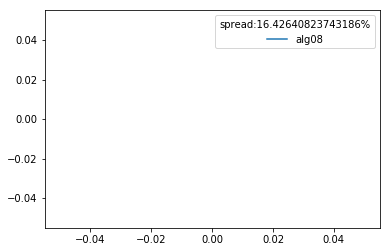

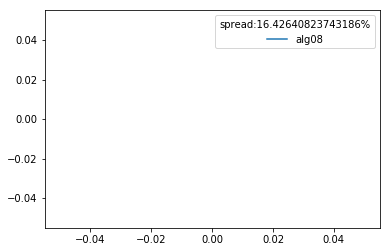

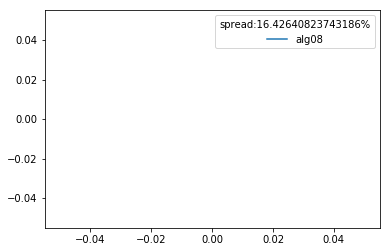

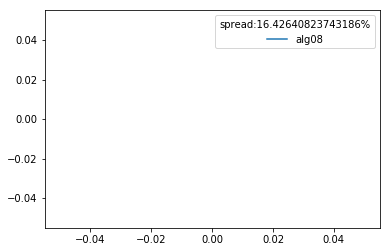

In [28]:
model.load_weights(SAVE_NAME)
alg01_40, alg03_40 = [],[]
alg01_50, alg03_50 = [],[]
alg01_55, alg03_55 = [],[]
alg09_50, alg09_55 = [],[]
for i in range(TRADING_DAYS):
    pred= model.predict(np.array(X[-DAY_SIZE*i:-(DAY_SIZE*(i-1))-1]))
    y= Y[-DAY_SIZE*i:-(DAY_SIZE*(i-1))-1]

    palg08 = plt.plot(iter_alg08(pred,y), label="alg08")
    

   
    plt.legend(title="spread:"+str(_spread)+"%")
    plt.show()